In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
# Import the loading function from xBOUT
from xbout import open_boutdataset

# Import xarray, which is the real hero here
import xarray as xr

### Loading data

To get the data for this tutorial you can either generate it or download it:
* generate by running the `blob2d` [example from the BOUT++ repository](https://github.com/boutproject/BOUT-dev/tree/master/examples/blob2d) (with the command `./blob2d -d delta_1` to produce output in the delta_1 directory as used in this example) and then copying its `BOUT.dmp.*.nc` (output files) to the `delta_1` subdirectory here.
* download by running the following Python cell.

In [3]:
# Download data files if you do not have them already
from pathlib import Path
import urllib.request
if not Path("delta_1/BOUT.dmp.0.nc").exists():
    urllib.request.urlretrieve(f"https://zenodo.org/record/4306115/files/BOUT.dmp.0.nc?download=1", f"delta_1/BOUT.dmp.0.nc")

In [4]:
# Open the data and see what's inside
ds = open_boutdataset("delta_1/BOUT.dmp.*.nc", inputfilepath="delta_1/BOUT.inp")

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset>
Dimensions:   (t: 51, x: 260, y: 1, z: 256)
Coordinates:
  * t         (t) float64 0.0 50.0 100.0 150.0 ... 2.4e+03 2.45e+03 2.5e+03
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 252 253 254 255 256 257 258 259
  * y         (y) float64 0.5
  * z         (z) float64 0.0 0.3 0.6 0.9 1.2 1.5 ... 75.3 75.6 75.9 76.2 76.5
Data variables:
    dx        (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    dy        (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g11       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g22       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g33       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g12       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g13       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g23       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.n

/home/jomotani/soltransport/pylib/xbout/xbout/load.py:248: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")
/home/jomotani/soltransport/pylib/xbout/xbout/geometries.py:151: UserWarning: Size of toroidal domain as calculated from nz*dz (76.8 is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


You can see all the variables, but none of them have been loaded yet, thanks to xarray's "lazy loading".

Each variable depends on dimensions or `dims`, which are like axes of numpy arrays but labelled with a name.

The `Dataset` is like a dictionary container of multiple `DataArrays`, each of which represents a simulation variable.

We have also stored various unphysical simulation quantities (such as processor splitting) in the `attrs` of the datasets, which is just a dictionary for carrying arbitrary extra info about the dataset's contents. 

Because we specified the path to the input file, the run options have also been included as a `BoutOptionsFile` object.

Currently the dataset is missing physical coordinates, as the warning mentions, but we will come back to that.

The object we've loaded is an `xarray.Dataset`, filled out in a sensible way for BOUT++ data. One way to think of it is as an in-memory representation of a netCDF file. Another way is like a set of numpy arrays with labelled axes. (If you've used pandas then it's also like a multidimensional pandas series.)

You will find the [xarray documentation](https://xarray.pydata.org/en/stable/index.html) useful.

In [ ]:
# You can see we have an unneccessary y dimension of length 1, so let's drop that
ds = ds.squeeze(drop=True)
ds

xarray is just wrapping numpy arrays, so we can always get our values back if we want

In [6]:
ds["t"].values

array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
       1350., 1400., 1450., 1500., 1550., 1600., 1650., 1700., 1750.,
       1800., 1850., 1900., 1950., 2000., 2050., 2100., 2150., 2200.,
       2250., 2300., 2350., 2400., 2450., 2500.])

### Basic plotting with xarray

<IPython.core.display.Javascript object>


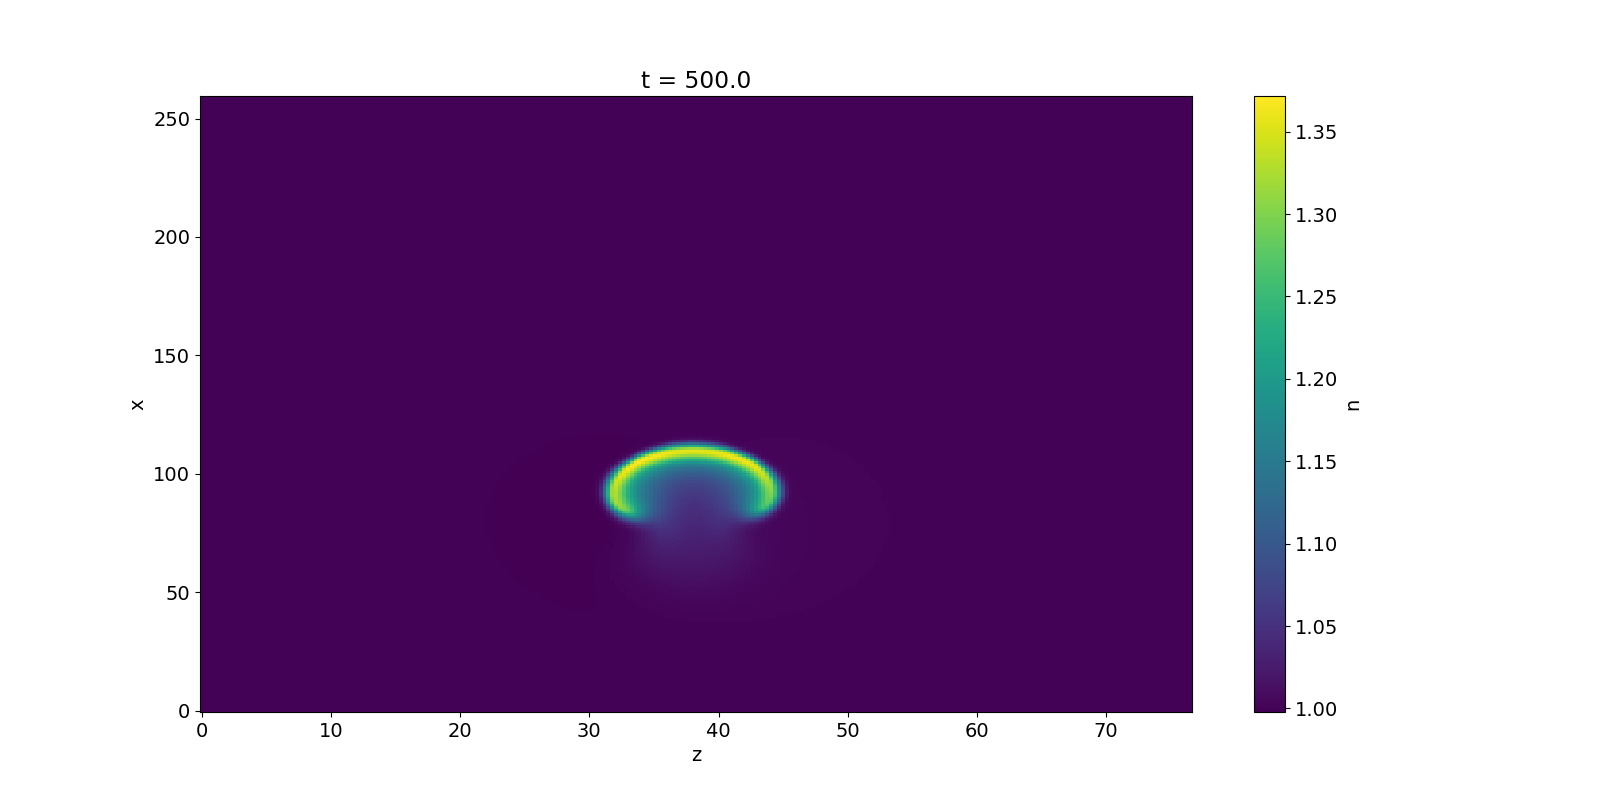

In [7]:
# What does the data look like? Let's try plotting a single frame
# Choose the density, at the 10th time index
plt.figure()
ds["n"].isel(t=10).plot()

## It's a blob!

Note xarray's `.plot()` method just wraps matplotlib, so you can pass matplotlib commands straight to it:

<IPython.core.display.Javascript object>


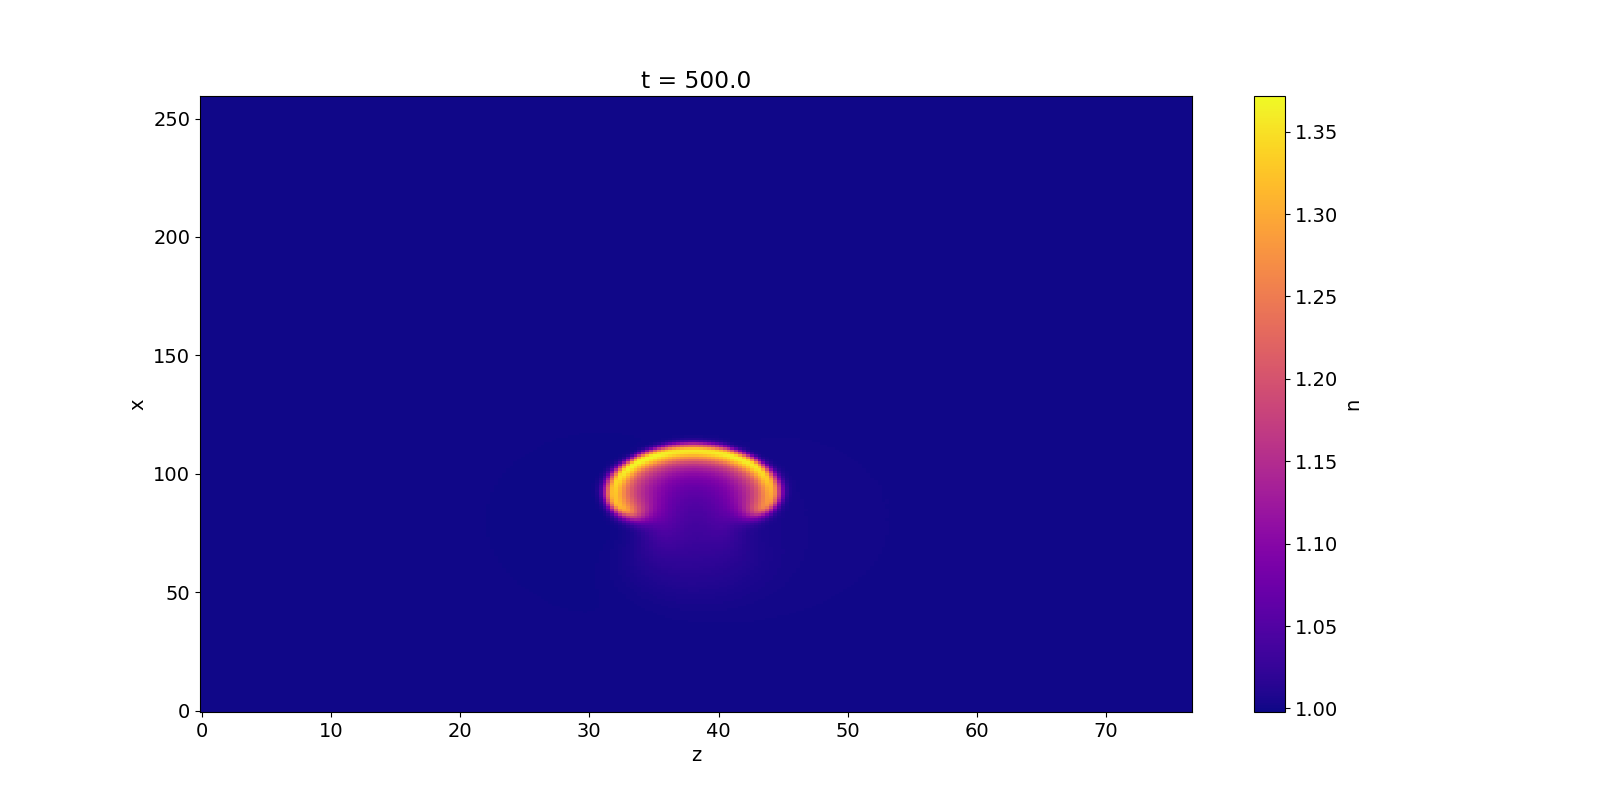

In [8]:
plt.figure()
ds["n"].isel(t=10).plot(cmap="plasma")

In [ ]:
# Let's watch it fly
ds["n"].bout.animate2D()

(xarray plots do not open a new figure, so we need to create a new one first. The `ds.bout` plotting and animation methods do create a new figure.)

In [ ]:
# Now let's animate everything
ds.bout.animate_list(["n", "phi", "omega"], ncols=3)

Swirly.

### Coordinates

Let's add some coordinates for the radial and binormal directions.

In [ ]:
# A z-coordinate gets created by default, since 'dz' is a scalar so it can always
# be used to define a 1d z-coordinate

# Let's use 'dx' to create an x-coordinate
x = ds["dx"].cumsum(dim="x")
ds = ds.assign_coords({"x": x})

# The time data in 't_array' has also been used by default to create the 't' coordinate

# Now we have a full set of coordinates!
ds

In [10]:
# (Aside:) It would be nice to do that every time we open our data, e.g.
def open_blob2ddataset(datapath="./BOUT.dmp.*", inputfilepath="./BOUT.inp", **kwargs):
    ds = open_boutdataset(datapath=datapath, inputfilepath=inputfilepath, **kwargs).squeeze(drop=True)

    # add physics-model-specific coordinates here
    x = ds["dx"].cumsum(dim="x")
    ds = ds.assign_coords({"x": x})

    return ds

Coordinates (or `coords`) are basically just data variables that have been given special status.

However, they can also be used to index the data.

### Indexing

In [ ]:
ds["n"].isel(t=10)  # selects the 10th slice along the t dimension

In [ ]:
ds["n"].sel(t=50)  # selects the slice which has a t value of 50

In [ ]:
# If you have scipy installed, you can also interpolate the data values
ds["n"].interp(t=55)

### Units

In [14]:
# The metadata can be read for plotting
ds["t"].attrs["units"] = "1/wci"
ds["x"].attrs["units"] = "rhos"
ds["z"].attrs["units"] = "rhos"

In [15]:
# We can un-normalise our data, so it's in physical units
n0 = ds.options["model"]["n0"]
ds["n"] = ds["n"] * n0
ds["n"].attrs["units"] = "m^-3"

<IPython.core.display.Javascript object>


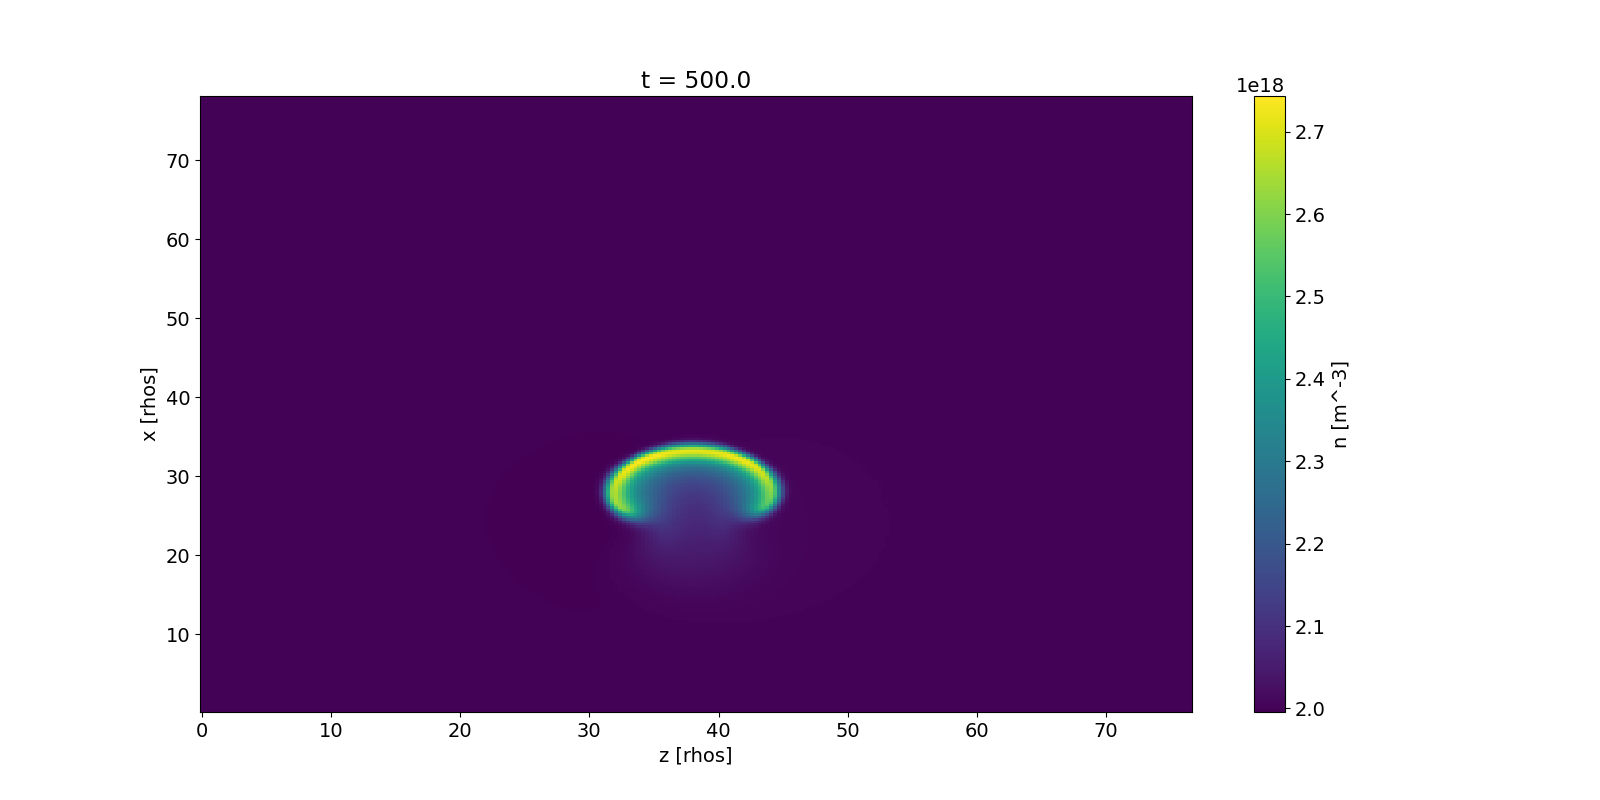

In [16]:
# Now if we plot again we will see the units too
plt.figure()
ds["n"].isel(t=10).plot()

### Now let's do some physics. 

Let's find the velocity of the centre-of-mass of just the filament.

<IPython.core.display.Javascript object>


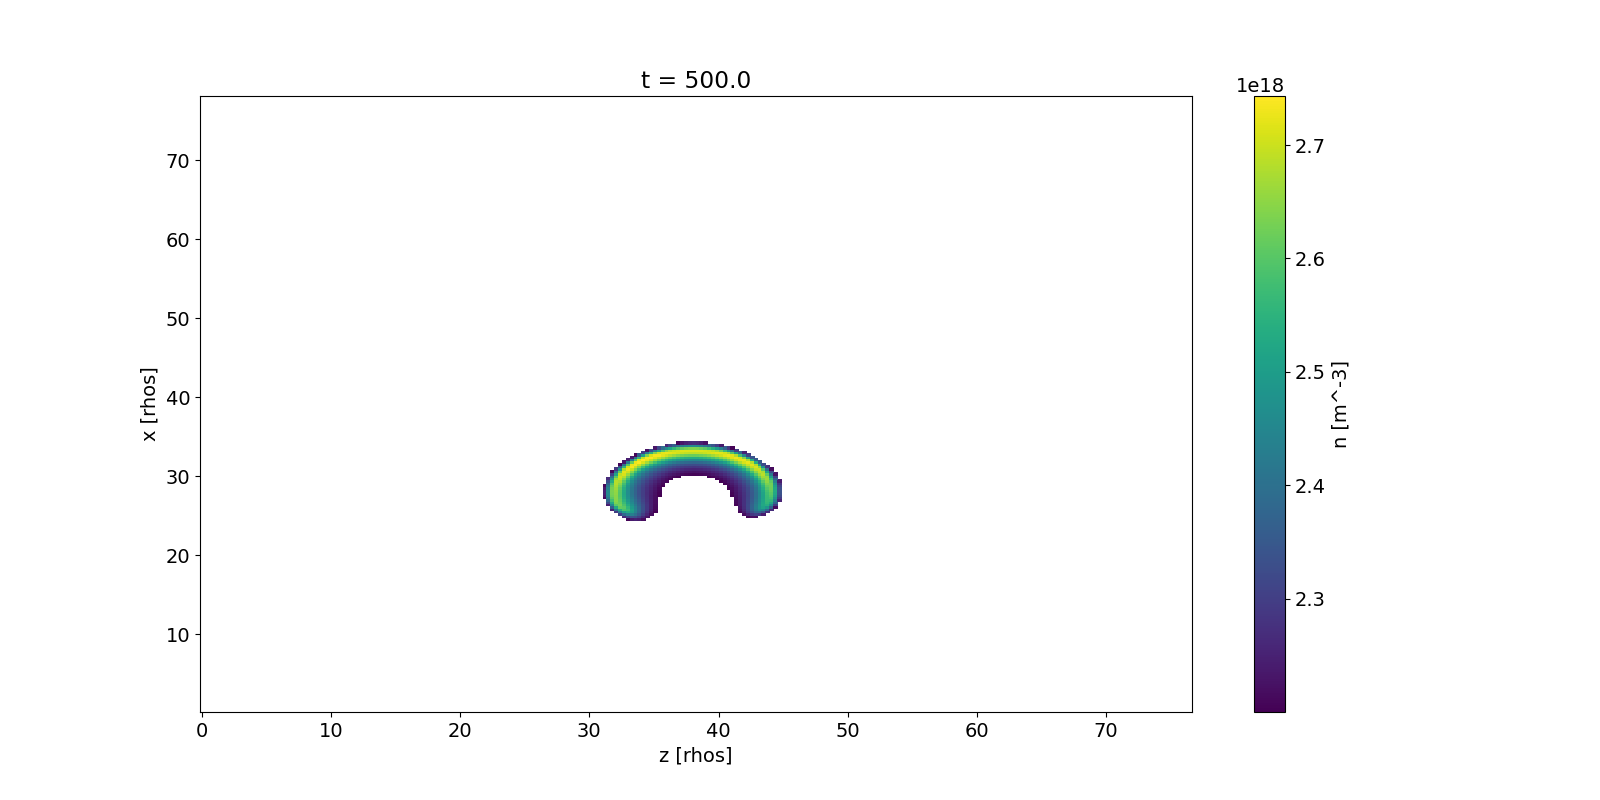

In [17]:
# Select just the filament, defined as the region with density greater than some multiple of the background
threshold = 1.1 * n0
blob = ds.where(ds["n"] > threshold)

# Now all the rest of the data has been replaced with NaNs
# xarray will exclude the NaNs when plotting
plt.figure()
blob["n"].isel(t=10).plot()

In [18]:
# Calculate centre-of-mass
n, x, z = ds["n"], ds["x"], ds["z"]

delta_n = n - n0
delta_n_total = delta_n.sum(dim=["x","z"])
xCoM = (x*delta_n).sum(dim=["x","z"]) / delta_n_total
zCoM = (z*delta_n).sum(dim=["x","z"]) / delta_n_total

<IPython.core.display.Javascript object>


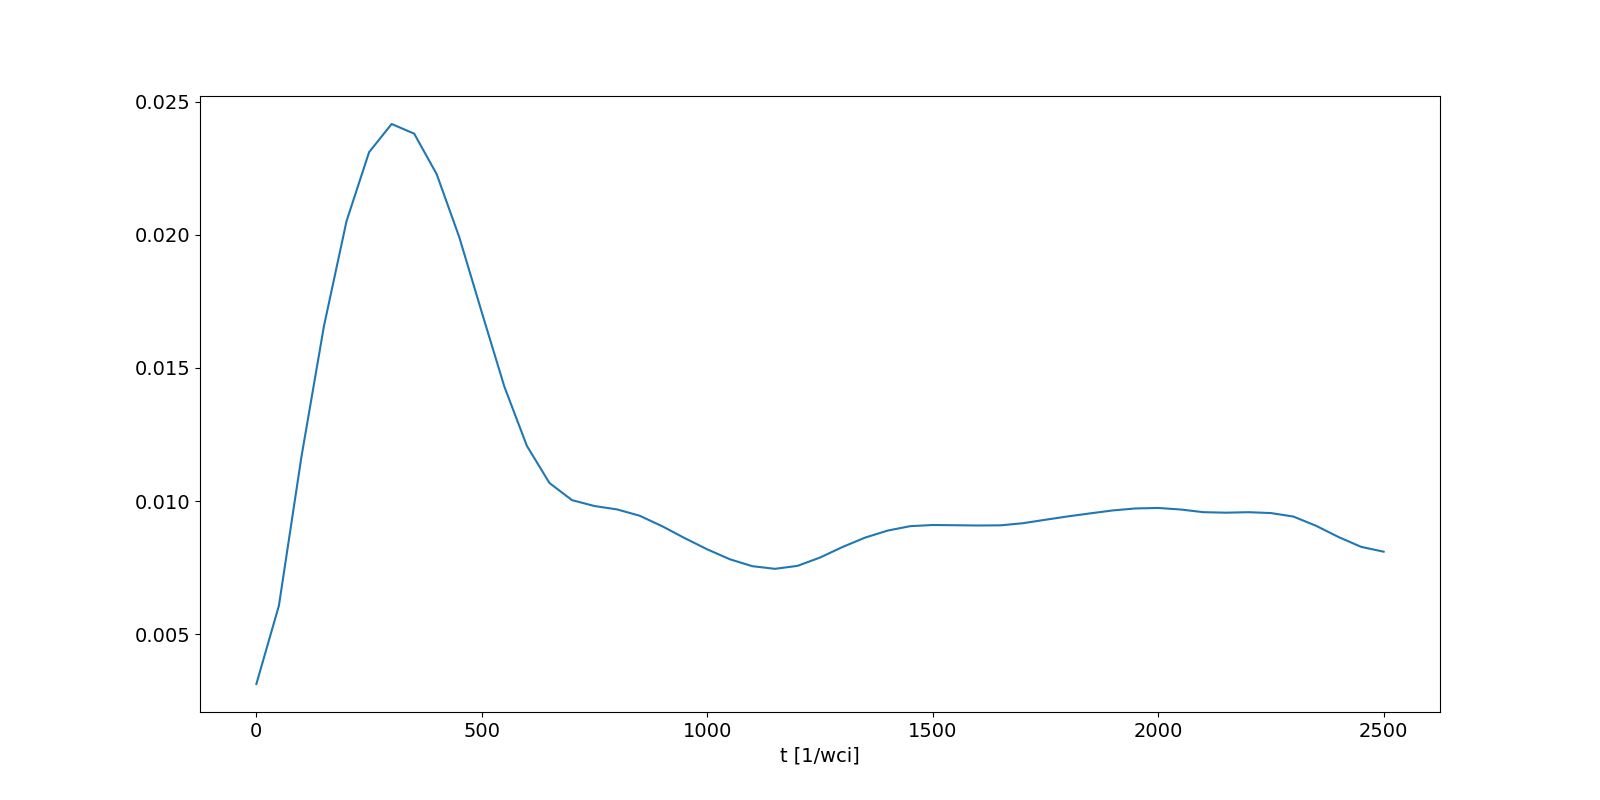

In [19]:
# Find velocity of CoM
v_xCoM = xCoM.differentiate("t")
v_zCoM = zCoM.differentiate("t")

# This quantity is 1D - but xarray knows to use a line plot to plot it 
plt.figure()
v_xCoM.plot()

<IPython.core.display.Javascript object>


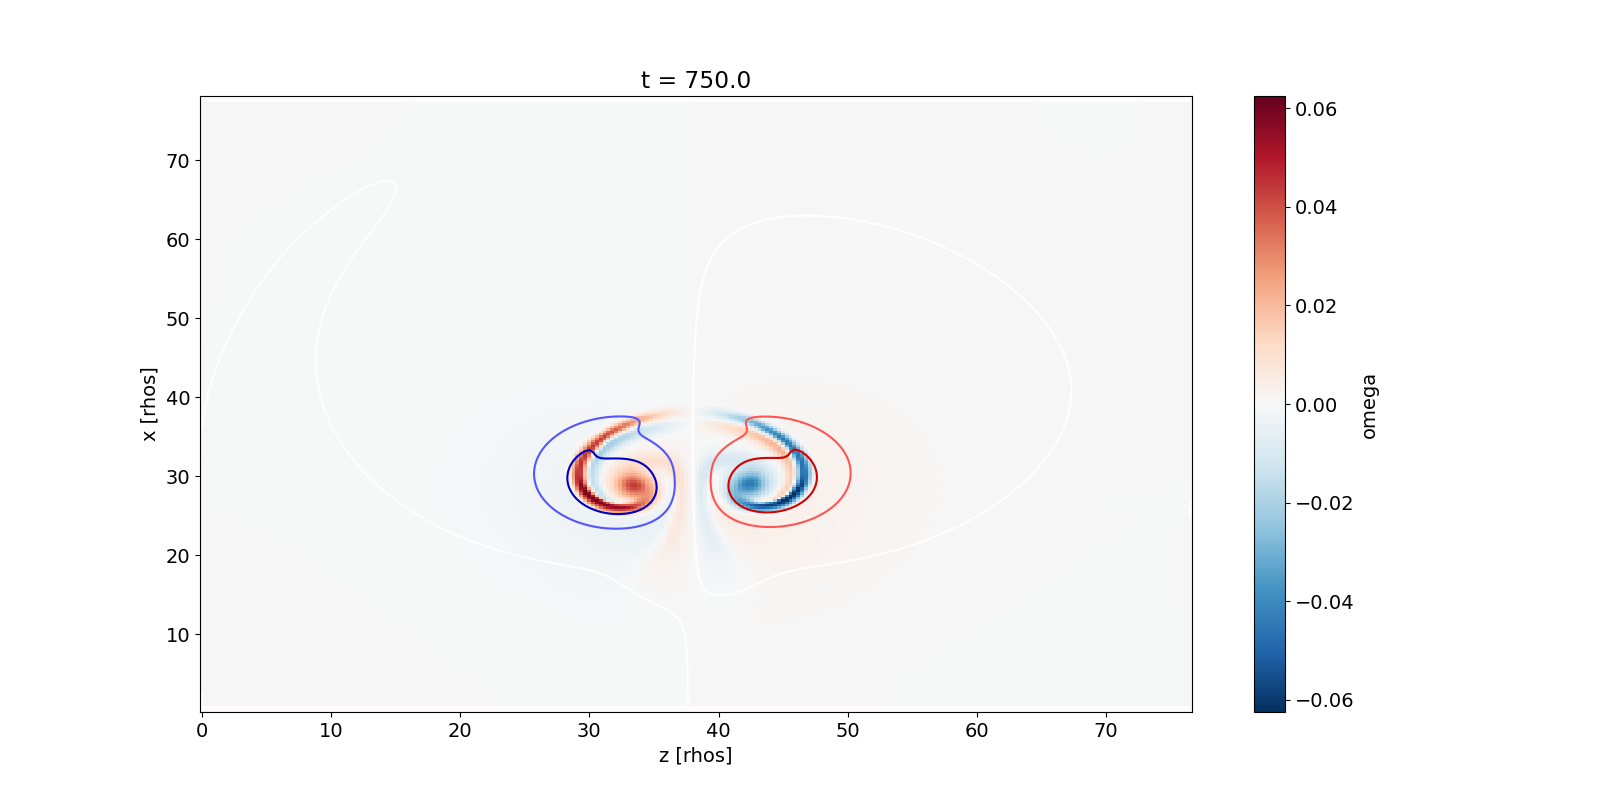

In [20]:
# Contours of electric potential on top of vorticity
plt.figure()
ds["omega"].isel(t=15).plot()
ds["phi"].isel(t=15).plot.contour(center=0.0, cmap="seismic")

## xBOUT's calc module

`xBOUT` is also a good place to store analysis methods and functions which are likely to be useful to many BOUT++ users. These should go in the `calc` module.

# Advanced

### Analysing multiple runs together

To include the additional simulations used in this section, either run the `delta_0.25` and `delta_10` cases in blob2d (but changed to 50 output timesteps of length 50, as set in the input files in the subdirectories here, to match the output times in the `delta_1` case), or download using the cell below.

In [21]:
if not Path("delta_0.25/BOUT.dmp.0.nc").exists():
    urllib.request.urlretrieve(f"https://zenodo.org/record/4306115/files/BOUT.dmp.0.nc_0.25?download=1", f"delta_0.25/BOUT.dmp.0.nc")
if not Path("delta_10/BOUT.dmp.0.nc").exists():
    urllib.request.urlretrieve(f"https://zenodo.org/record/4306115/files/BOUT.dmp.0.nc_10?download=1", f"delta_10/BOUT.dmp.0.nc")

In [22]:
# We can load the results from multiple simulation runs into a single dataset.
# This is great for analysing parameter scans
widths = [0.25, 1, 10]
runs = []
for w in widths:
    run = open_blob2ddataset(datapath=f"./delta_{w}/BOUT.dmp.*.nc", inputfilepath=f"./delta_{w}/BOUT.inp", info=False)
    # "x" and "z" are 'dimension coordinates' (because they have the same name as 'dimensions')
    # which means they are 'indexes' in xarray terminology. xarray would merge them into a single
    # array coordinate with all values rather than concatenating along "w", so make them regular
    # 'coordinates'. 
    run = run.reset_index(["x", "z"])
    runs.append(run)

width_coord = xr.DataArray(widths, dims="w", name="w")
scan = xr.concat(runs, dim=width_coord)
print(scan)

/home/jomotani/soltransport/pylib/xbout/xbout/geometries.py:151: UserWarning: Size of toroidal domain as calculated from nz*dz (9.6 is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(
/home/jomotani/soltransport/pylib/xbout/xbout/geometries.py:151: UserWarning: Size of toroidal domain as calculated from nz*dz (76.8 is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


<xarray.Dataset>
Dimensions:   (t: 51, w: 3, x: 260, z: 256)
Coordinates:
  * t         (t) float64 0.0 50.0 100.0 150.0 ... 2.4e+03 2.45e+03 2.5e+03
    x_        (w, x) float64 0.0375 0.075 0.1125 0.15 ... 258.0 259.0 260.0
    z_        (w, z) float64 0.0 0.0375 0.075 0.1125 ... 252.0 253.0 254.0 255.0
  * w         (w) float64 0.25 1.0 10.0
Dimensions without coordinates: x, z
Data variables:
    dx        (w, x) float64 dask.array<chunksize=(1, 260), meta=np.ndarray>
    dy        (w, x) float64 dask.array<chunksize=(1, 260), meta=np.ndarray>
    g11       (w, x) float64 dask.array<chunksize=(1, 260), meta=np.ndarray>
    g22       (w, x) float64 dask.array<chunksize=(1, 260), meta=np.ndarray>
    g33       (w, x) float64 dask.array<chunksize=(1, 260), meta=np.ndarray>
    g12       (w, x) float64 dask.array<chunksize=(1, 260), meta=np.ndarray>
    g13       (w, x) float64 dask.array<chunksize=(1, 260), meta=np.ndarray>
    g23       (w, x) float64 dask.array<chunksize=(1, 260), m

/home/jomotani/soltransport/pylib/xbout/xbout/geometries.py:151: UserWarning: Size of toroidal domain as calculated from nz*dz (256.0 is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


In [23]:
n, x, z = scan["n"], scan["x_"], scan["z_"]
delta_n = n - 1.0
delta_n_total = delta_n.sum(dim=["x","z"])
xCoM = (x*delta_n).sum(dim=["x","z"]) / delta_n_total
    
# Shift to be distance relative to the starting point
xCoM = xCoM - xCoM.isel(t=0)

Note that this wouldn't work with the standard blob2d example data.
That's because the default options for the three cases produce time series of different lengths and with different time-steps.

That's why we had to modify the inputs to have the same number and length of time-steps to combine them like this.

Now we have all the runs together, we can compare them easily...

<IPython.core.display.Javascript object>


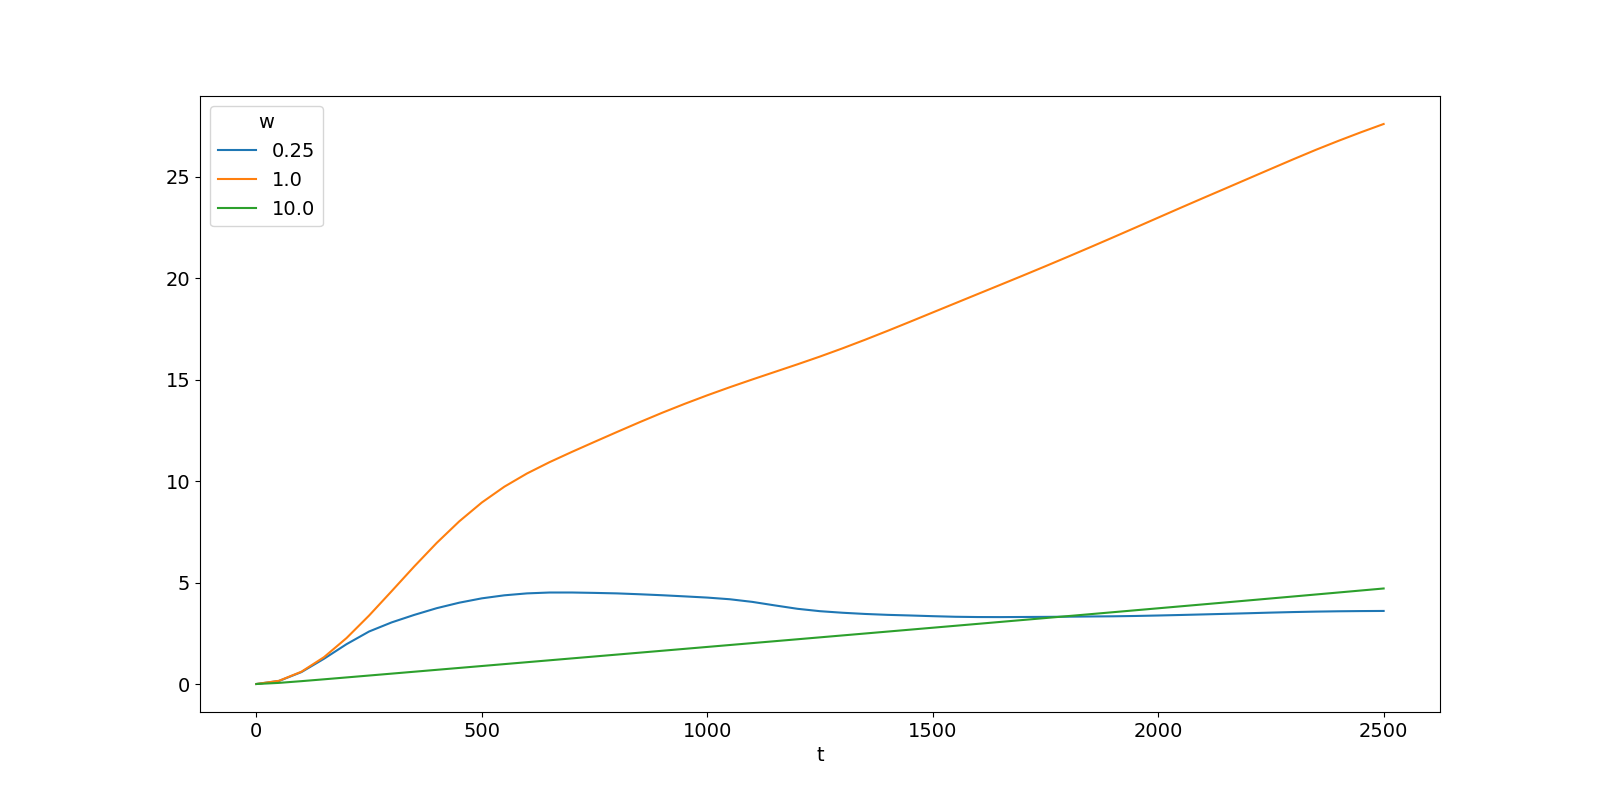

In [24]:
# Plot the centre-of-mass positions
plt.figure()
xCoM.plot(hue="w")

More things to do:
* Plot of average velocities against amplitude?
* Compare to analytic scaling?

### Physics-model-specific accessors

`xbout` achieves the `ds.bout.method()` syntax by using the ["accessor"](https://xarray.pydata.org/en/stable/internals.html#extending-xarray) interface provided by xarray.

This is great because it allows us to attach domain specific functionality (i.e. tokamak-specific plotting methods) to general data structures (i.e. `xarray.Dataset` objects).

We can go further though.

The accessor classes `BoutDatasetAccessor` and `BoutDataArrayAccessor` are intended to be subclassed for specific BOUT++ modules. 
The subclass accessor will then inherit all the `.bout` accessor methods, but you will also be able to override these and define your own methods within your new accessor.

For example to add an extra method specific to the STORM BOUT++ module:

In [25]:
from xarray import register_dataset_accessor
from xbout.boutdataset import BoutDatasetAccessor

@register_dataset_accessor("storm")
class StormAccessor(BoutDatasetAccessor):
    def __init__(self, ds_object):
        super().__init__(ds_object)

    def special_method(self):
        print("Do something only STORM users would want to do")

ds.storm.special_method()

Do something only STORM users would want to do


### Example of using accessors

In [26]:
from xarray import register_dataset_accessor

from xbout import BoutDatasetAccessor, BoutDataArrayAccessor


@register_dataset_accessor("utils")
class UtilityDatasetAccessor(BoutDatasetAccessor):
    """
    Class specifically for calculating ExB velocities of BOUT++ data.
    
    Requires that the BOUT++ data has a 'phi' field and 'x' and 'z' coordinates,
    in addition to the default 'Bxy' magnetic field.
    """

    def __init__(self, ds):
        super().__init__(ds)
        self.data = ds

    # This is where module-specific methods would go
    # For example maybe elm-pb would have a .elm_growth_rate() method?

    @property
    def v_radial(self):
        """Calculates local radial ExB velocity"""

        if "v_radial" not in self.data:
            E_z = self.data["phi"].differentiate(coord="z")
            v_radial = E_z / self.data["Bxy"]
            v_radial.attrs["standard_name"] = "radial velocity"
            self.data["v_radial"] = v_radial
        return self.data["v_radial"]

    @property
    def v_binormal(self):
        """Calculates local binormal ExB velocity"""

        if "v_binormal" not in self.data:
            E_x = self.data["phi"].differentiate(coord="x")
            v_binormal = -E_x / self.data["Bxy"]
            v_binormal.attrs["standard_name"] = "binormal velocity"
            self.data["v_binormal"] = v_binormal
        return self.data["v_binormal"]

We've written the methods in like this (using the property decorator) so that they can be calculated like variables which already exist, and then saved on the dataset.

In [ ]:
# Choose a time slice, downsample, and select region of interest
bd = ds.isel(t=10, x=slice(50, 150, 3), z=slice(75, 175, 3))

# Find ExB velocities
vx = bd.utils.v_radial
vz = bd.utils.v_binormal

bd

<IPython.core.display.Javascript object>


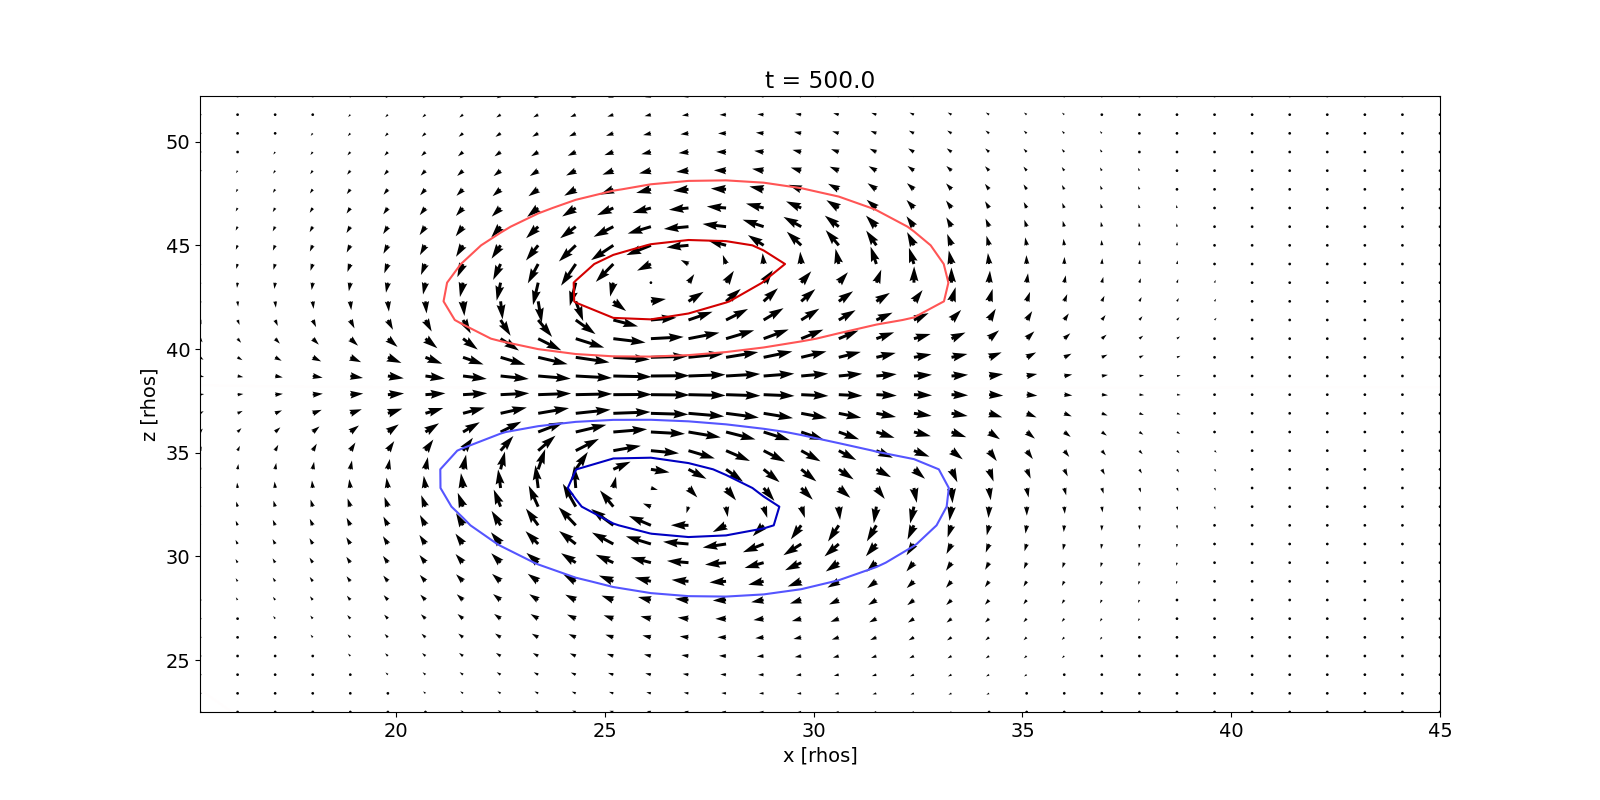

In [28]:
# Plot streamlines
fig, ax = plt.subplots()
bd["phi"].transpose().plot.contour(center=0.0, cmap="seismic", ax=ax)

# Plot the flow
# (we're using pure matplotlib so have to match up the dimensions)
x, z = bd["x"].broadcast_like(vx), bd["z"].broadcast_like(vx)
ax.quiver(x.values, z.values, vx.values, vz.values, scale=1.7)

### Your own data

If you have some of your own data, try loading that.
For 3D tokamak datasets specify `geometry="toroidal"` in `open_boutdataset`.
Then when plotting try `ds[var].bout.pcolormesh()`